# Brain-Computer Interfaces (Fall 2017, ELE 594) 
# Instructor: Yalda Shahriari
# 3th homework, 11/1/17 (The homework, is due by Nov 8th, 11:55 pm).

Part 2:
Instructions for part 2:
In this part, use the dataset you recorded yourselves for eye blink, eye closed, eye open, and teeth clench conditions.

2- 
(a) Compute the power spectral density (PSD) of the entire eyes open and eyes closed conditions for channel “Oz”.

Plot the resulting PSD from 0-70 Hz (i.e., both eyes open and eyes closed conditions in one plot) in the same plot, with separate subplots for each subject. 

Be sure to use common axis with clear labels for each subject.

Hint: For PSD use 256-pt pwelch Matlab function. 

For parameters, use windows of 1-second with 50% overlap. 

All the PSD plots should be in 10log10 scale.

(b) Identify the peak alpha frequency for each subject and plot the topographies for the eyes open and closed condition. 

Use separate subplots and colorbars for each subject.

In [61]:
# Import necessary libraries and functions
import numpy as np
# , cmath, scipy as sp
import scipy.io
from matplotlib import pyplot as plt

#import basic functions from numpy that we'll need
from numpy import *
from numpy.fft import fft, ifft
from scipy import signal as sig
from scipy.signal import hilbert

from matplotlib.pyplot import *

%matplotlib inline

# Import optional library for pretty plots
# import seaborn as sns
# sns.set_palette('muted')
# sns.set_style('darkgrid')

load the sample EEG data

In [67]:
data = scipy.io.loadmat('sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]

EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


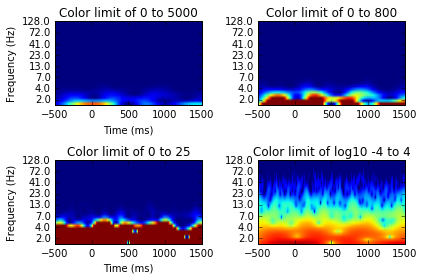

In [71]:
#wavelet parameters
min_freq = 2
max_freq = 128
num_frex = 30

#other wavelet parameters
frequencies = logspace(log10(min_freq),log10(max_freq),num_frex)
time = np.arange(-1,1+1/EEGsrate,1/EEGsrate)
half_of_wavelet_size = (len(time)-1)/2

def nextpow2(n):
    m_f = np.log2(n)
    m_i = np.ceil(m_f)
    return 2**m_i

#FFT parameters (use next-power-of-2)
n_wavelet     = len(time)
n_data        = EEGpnts;
n_convolution = n_wavelet+n_data-1;
n_conv_pow2   = int(nextpow2(n_convolution))
wavelet_cycles= 4

#FFT of data (note: this doesn't change on frequency iteration)
fft_data = fft(squeeze(EEGdata[22,:,0]),n_conv_pow2)

#initialize output time-frequency data
tf_data = zeros([len(frequencies),EEGpnts])


for fi in range(len(frequencies)):
    
    #create wavelet and get its FFT
    wavelet = (pi*frequencies[fi]*sqrt(pi))**(-.5) * exp(2*1j*pi*frequencies[fi]*time)* exp(-time**2/(2*( wavelet_cycles /(2*pi*frequencies[fi]))**2))/frequencies[fi]                                                                                                 
                                                                                                      
    fft_wavelet = fft(wavelet,n_conv_pow2)
    
    #run convolution
    convolution_result_fft = ifft(fft_wavelet*fft_data,n_conv_pow2)
    convolution_result_fft = convolution_result_fft[:n_convolution] # note: here we remove the extra points from the power-of-2 FFT
    convolution_result_fft = convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size]
    
    #put power data into time-frequency matrix
    tf_data[fi,:] = np.abs(convolution_result_fft)**2
    
    
ytickskip = np.arange(2,num_frex+4,4)# This will be explained in the text.

subplot(221)
imshow(tf_data,origin="lower",aspect="auto",
       cmap=cm.jet, vmin=0, vmax=5000,
       extent=[-500,1500,0,30])
plt.setp(plt.gca(),'yticks',ytickskip,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-500, 1500])
xlabel('Time (ms)')
ylabel('Frequency (Hz)')
title('Color limit of 0 to 5000') 

subplot(222)
imshow(tf_data,origin="lower",aspect="auto"
       ,cmap=cm.jet, vmin=0, vmax=800,
      extent=[-500,1500,0,30])
plt.setp(plt.gca(),'yticks',ytickskip,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-500, 1500])
title('Color limit of 0 to 800') 

subplot(223)
imshow(tf_data,origin="lower",aspect="auto"
       ,cmap=cm.jet, vmin=0, vmax=25,
      extent=[-500,1500,0,30])
plt.setp(plt.gca(),'yticks',ytickskip,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-500, 1500])
title('Color limit of 0 to 25') 
xlabel('Time (ms)')
ylabel('Frequency (Hz)')

subplot(224)
imshow(log10(tf_data),origin="lower",aspect="auto"
       ,cmap=cm.jet, vmin=-4, vmax=4,
      extent=[-500,1500,0,30])
plt.setp(plt.gca(),'yticks',ytickskip,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-500, 1500])
title('Color limit of log10 -4 to 4') 

tight_layout()

Figure 18.3

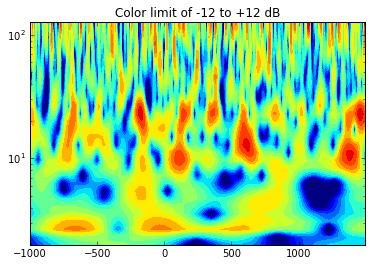

In [72]:
# define baseline period
baselinetime = np.array([ -500, -200 ])

baselineidx =np.zeros(2,dtype=int)

# convert baseline window time to indices
baselineidx[0]=argmin(np.abs(EEGtimes-baselinetime[0]))
baselineidx[1]=argmin(np.abs(EEGtimes-baselinetime[1]))


#dB-correct
baseline_power = mean(tf_data[:,baselineidx[0]:baselineidx[1]],axis=1)
dbconverted = 10*log10( tf_data/np.reshape(baseline_power,[len(baseline_power),1]))
# FYI: the following line of code are equivalent to the previous line (numpy's broadcasting is a wonderful thing):
dbconverted = 10*( log10(tf_data)- np.reshape(log10(baseline_power),[len(baseline_power),1]))


contourf(EEGtimes,frequencies,dbconverted,40,vmin=-12,vmax=12,cmap=cm.jet)
setp(gca(),'yticks',np.round(logspace(log10(frequencies[0]),log10(frequencies[-1])*100)/100))
plt.yscale('log')
                          
_=title('Color limit of -12 to +12 dB')

Figure 18.4

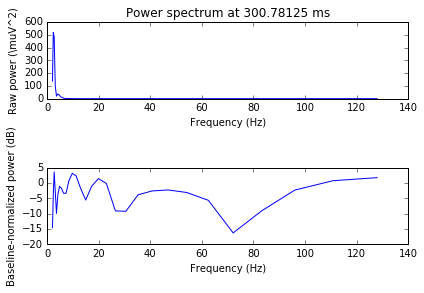

In [73]:
time2plot = 300 # in ms


timeidx = argmin(np.abs(EEGtimes-time2plot))


subplot(211)
plot(frequencies,tf_data[:,timeidx])
title( 'Power spectrum at ' + str(EEGtimes[timeidx]) + ' ms' )
ylabel('Raw power (\muV^2)')
xlabel('Frequency (Hz)')

subplot(212)
plot(frequencies,dbconverted[:,timeidx])
ylabel('Baseline-normalized power (dB)')
xlabel('Frequency (Hz)')

tight_layout()

Figure 18.5

In [24]:
#This figure was created by changing the color limits of figure 18.3

Figure 18.6

dB of -2 corresponds to -37.0% change.
dB of +2 corresponds to +58.0% change.


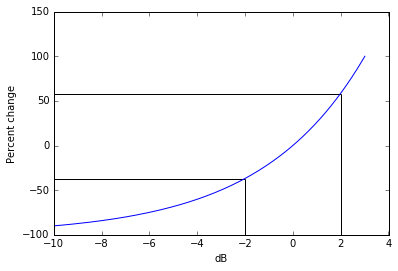

In [25]:
activity = np.arange(1,20+.1,.1) # activity
baseline = 10 # baseline

db = 10*log10(activity/ baseline )
pc = 100*( activity-baseline)/ baseline

plot(db,pc)
xlabel('dB'), ylabel('Percent change')

#find indices where db is closest to -/+2
dbOf2=argmin(np.abs(db-2));
dbOfminus2=argmin(np.abs(db--2))

print  ('dB of -2 corresponds to ' + str(pc[dbOfminus2]) + '% change.') 
print ('dB of +2 corresponds to +' + str(pc[dbOf2]) + '% change.') 


vlines(2,-100,pc[dbOf2])
hlines(pc[dbOf2],-10,2)

vlines(-2,-100,pc[dbOfminus2])
_=hlines(pc[dbOfminus2],-10,-2)

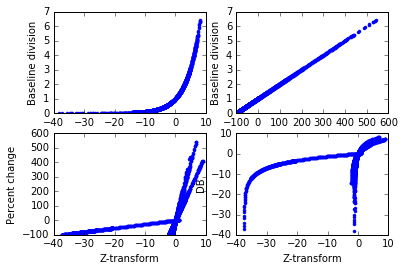

In [28]:
# real data: percent change vs. baseline division
baseline_power = mean(tf_data[:,baselineidx[0]:baselineidx[1]],axis=1)

pctchange = 100 * (tf_data - reshape(baseline_power,[len(baseline_power),1]))/reshape(baseline_power,[len(baseline_power),1])

subplot(221)
baselinediv = tf_data / reshape(baseline_power,[len(baseline_power),1])
plot(dbconverted[::5],baselinediv[::5],'.b') # don't need all the datapoints to make a point
xlabel('DB'), ylabel('Baseline division')

# dB vs. baseline division
subplot(222)
plot(pctchange[::5],baselinediv[::5],'.b')
xlabel('Percent change'), ylabel('Baseline division')

# Z-transform vs. percent change
subplot(223)
baseline_power = tf_data[:,baselineidx[0]:baselineidx[1]];
baselineZ = (tf_data - reshape(mean(baseline_power,axis=1),[len(baseline_power),1]))/reshape(std(baseline_power,axis=1),[len(baseline_power),1])

plot(baselineZ[::5],pctchange[::5],'.b')
xlabel('Z-transform'), ylabel('Percent change')

#Z-transform vs. dB
subplot(224)
plot(baselineZ[::5],dbconverted[::5],'.b')
_=xlabel('Z-transform'), ylabel('DB')

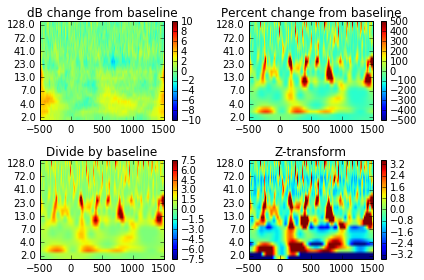

In [31]:
#plot dB-converted power
subplot(221)
imshow(dbconverted, aspect='auto',cmap=cm.jet,vmin=-10,vmax=10, origin='lower', extent=[-500,1500,0,30])

setp(gca(),'yticks',ytickskip-1,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-500, 1500])
title('dB change from baseline')
colorbar()
# plot percent-change
subplot(222)
imshow(pctchange, aspect='auto',cmap=cm.jet,vmin=-500,vmax=500, origin='lower', extent=[-500,1500,0,30])

setp(gca(),'yticks',ytickskip-1,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-500, 1500])
title('Percent change from baseline')
colorbar()


# divide by baseline
subplot(223)
imshow(baselinediv, aspect='auto',cmap=cm.jet,vmin=-7.5,vmax=7.5, origin='lower', extent=[-500,1500,0,30])
setp(gca(),'yticks',ytickskip-1,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-500, 1500])
title('Divide by baseline')
colorbar()


# z-transform
subplot(224)
imshow(baselineZ, aspect='auto',cmap=cm.jet,vmin=-3.5,vmax=3.5, origin='lower', extent=[-500,1500,0,30])
setp(gca(),'yticks',ytickskip-1,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-500, 1500])
title('Z-transform')
colorbar()

tight_layout()

Figure 18.8

/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


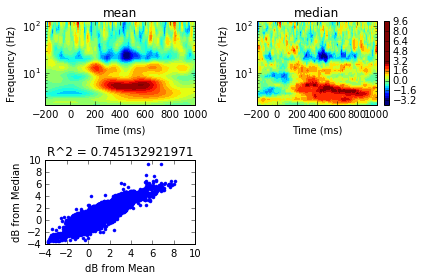

In [32]:
chan2plot = 'FCz' # p1 for figure 18.11
# define baseline period
baselinetime = np.array([ -500, -200 ])# in ms

# convert baseline window time to indices
baselineidx[0] = argmin(np.abs(EEGtimes-baselinetime[0]))
baselineidx[1] = argmin(np.abs(EEGtimes-baselinetime[1]))

tf_data = zeros([2,len(frequencies),EEGpnts])

n_data        = EEGpnts*EEGtrials;
n_convolution = n_wavelet+n_data-1;
n_conv_pow2   = int(nextpow2(n_convolution))

fft_data = fft(reshape(EEGdata[EEGchanlocslabels == chan2plot,:,:],[640*99],'F'),n_conv_pow2)

for fi in range(len(frequencies)):
    
    #create wavelet and get its FFT
    wavelet = (pi*frequencies[fi]*sqrt(pi))**-.5 * exp(2*1j*pi*frequencies[fi]*time)* exp(-time**2/(2*( wavelet_cycles /(2*pi*frequencies[fi]))**2))/frequencies[fi]
    fft_wavelet = fft(wavelet,n_conv_pow2)
    
    #run convolution
    convolution_result_fft = ifft(fft_wavelet*fft_data,n_conv_pow2)
    convolution_result_fft = convolution_result_fft[:n_convolution]
    convolution_result_fft = convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size]
    convolution_result_fft = reshape(convolution_result_fft,[EEGpnts,EEGtrials],'F')
    
    if fi==6: # save single-trial data from one frequency band
        convdat2keep = convolution_result_fft
    
    
    # put power data into time-frequency matrix
    tf_data[0,fi,:] = mean(np.abs(convolution_result_fft)**2,axis=1)
    tf_data[1,fi,:] = median(np.abs(convolution_result_fft)**2,axis=1)

#db-correct and plot
labelz = ['mean','median']

for i in range(2):
    baseline_power = mean(tf_data[i,:,baselineidx[0]:baselineidx[1]],axis=1)
    dbconverted = 10*log10(tf_data[i,:,:]/reshape(baseline_power,[len(baseline_power),1]))
    
    # plot
    subplot(2,2,i+1)
    contourf(EEGtimes,frequencies,dbconverted,40,vmin=-3,vmax=3,cmap=cm.jet)

    setp(gca(),'xlim',[-200, 1000],'yticks',logspace(log10(frequencies[0]),log10(frequencies[-1]),6),'yticklabels',np.round(logspace(log10(frequencies[0]),log10(frequencies[-1]),6)*10)/10)
    plt.yscale('log')
    title(labelz[i]), ylabel('Frequency (Hz)'), xlabel('Time (ms)')
colorbar()    


#plot relationship between mean and median
subplot(223)

db_mean = 10*log10( tf_data[0,:,:]/reshape(mean(tf_data[0,:,baselineidx[0]:baselineidx[1]],axis=1),[30,1]))
db_medn = 10*log10( tf_data[1,:,:]/reshape(mean(tf_data[1,:,baselineidx[0]:baselineidx[1]],axis=1),[30,1]))

plot(db_mean[:],db_medn[:],'.b')
r=np.corrcoef(ravel(db_mean[:]),ravel(db_medn[:]))[0,1]
title( 'R^2 = ' +str(r*r) )
xlabel('dB from Mean')
ylabel('dB from Median')

tight_layout()

Figure 18.9

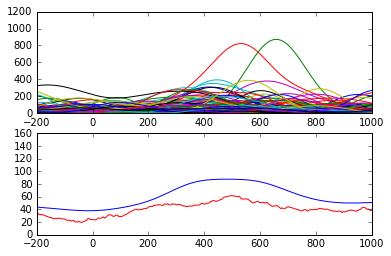

In [33]:
# plot all trials, mean, and median

subplot(211)
plot(EEGtimes,np.abs(convdat2keep)**2)
setp(gca(),'xlim',[-200, 1000])

subplot(212)
plot(EEGtimes,mean(np.abs(convdat2keep)**2,axis=1))
plot(EEGtimes,median(np.abs(convdat2keep)**2,axis=1),'r')
_=setp(gca(),'xlim',[-200, 1000])

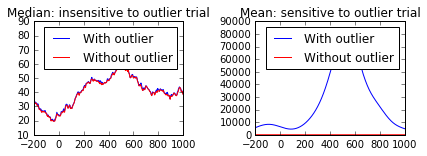

In [36]:
# to make this point even more clear, add an outlier trial
convdat2keep[:,98] = convdat2keep[:,9]*100;

subplot(221)
plot(EEGtimes,median(np.abs(convdat2keep)**2,axis=1))

plot(EEGtimes,median(np.abs(convdat2keep[:,:-1])**2,axis=1),'r')
setp(gca(),'xlim',[-200, 1000])
legend(['With outlier','Without outlier'])
title('Median: insensitive to outlier trial')

subplot(222)
plot(EEGtimes,mean(np.abs(convdat2keep)**2,axis=1))

plot(EEGtimes,mean(np.abs(convdat2keep[:,:-1])**2,axis=1),'r')
setp(gca(),'xlim',[-200, 1000])
legend(['With outlier','Without outlier'])
title('Mean: sensitive to outlier trial')

tight_layout()

Figure 18.10

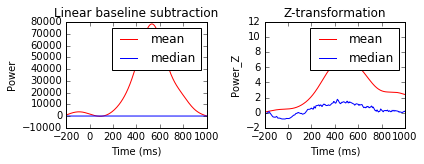

In [37]:
#convenientize power
convdatPower  = np.abs(convdat2keep)**2;

#single-trial linear baseline correction
convdat2keepB = convdatPower - mean(convdatPower[baselineidx[0]:baselineidx[1],:],axis=0)

#single-trial Z score
convdat2keepZ = (convdatPower - mean(convdatPower[baselineidx[0]:baselineidx[1],:],axis=0)) / std(convdatPower[baselineidx[0]:baselineidx[1],:],axis=0)

#single-trial log10
convdat2keepL = log10(convdatPower)

subplot(221)
plot(EEGtimes,mean(convdat2keepB,axis=1),'r')

plot(EEGtimes,median(convdat2keepB,axis=1),'b')
xlabel('Time (ms)'), ylabel('Power')
setp(gca(),'xlim',[-200, 1000])
title('Linear baseline subtraction'),legend(['mean','median'])

subplot(222)
plot(EEGtimes,mean(convdat2keepZ,axis=1),'r')
plot(EEGtimes,median(convdat2keepZ,axis=1),'b')
xlabel('Time (ms)'), ylabel('Power_Z')
setp(gca(),'xlim',[-200, 1000])
_=title('Z-transformation'),legend(['mean','median'])
tight_layout()

Figure 18.11

In [38]:
#This figure was made by running the code for figure 28.8 but using P1
# instead of FCz. (Fewer frequencies were also plotted.)

Figure 18.12

/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  del sys.path[0]


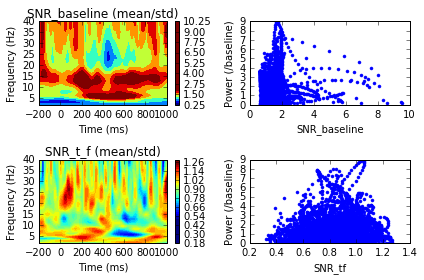

In [39]:
snr_bs = zeros([len(frequencies),EEGpnts])
snr_tf = zeros([len(frequencies),EEGpnts])

for fi in range(len(frequencies)):
    
    #create wavelet and get its FFT
    wavelet = (pi*frequencies[fi]*sqrt(pi))**-.5 * exp(2*1j*pi*frequencies[fi]*time)* exp(-time**2/(2*( wavelet_cycles /(2*pi*frequencies[fi]))**2))/frequencies[fi] 
    fft_wavelet = fft(wavelet,n_conv_pow2)
    
    #run convolution
    convolution_result = ifft(fft_wavelet*fft_data,n_conv_pow2) * sqrt(wavelet_cycles /(2*pi*frequencies[fi]))
    convolution_result = convolution_result[:n_convolution]
    convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]
    convolution_result = reshape(convolution_result,[EEGpnts,EEGtrials],'F')
    
    #extract SNR in two ways
    snr_tf[fi,:] = mean(np.abs(convolution_result)**2,axis=1)/std(np.abs(convolution_result)**2,axis=1)
    snr_bs[fi,:] = mean(np.abs(convolution_result)**2,axis=1)/std(mean(np.abs(convolution_result[baselineidx[0]:baselineidx[1],:])**2,axis=0))

# plot

subplot(221)
contourf(EEGtimes,frequencies,snr_bs,40,vmin=.5,vmax=2,cmap=cm.jet)
setp(gca(),'xlim',[-200, 1000],'ylim',[frequencies[0], 40])
title('SNR_baseline (mean/std)'), ylabel('Frequency (Hz)'), xlabel('Time (ms)')
colorbar()

subplot(222)
plot(snr_bs[::3],baselinediv[::3],'b.')
xlabel('SNR_baseline'), ylabel('Power (/baseline)')

subplot(223)
contourf(EEGtimes,frequencies,snr_tf,40,vmin=.5,vmax=1.25,cmap=cm.jet)
setp(gca(),'xlim',[-200, 1000],'ylim',[frequencies[0], 40])
title('SNR_t_f (mean/std)'), ylabel('Frequency (Hz)'), xlabel('Time (ms)')
colorbar()

subplot(224)
plot(snr_tf[::3],baselinediv[::3],'b.')
xlabel('SNR_tf'), ylabel('Power (/baseline)')

tight_layout()

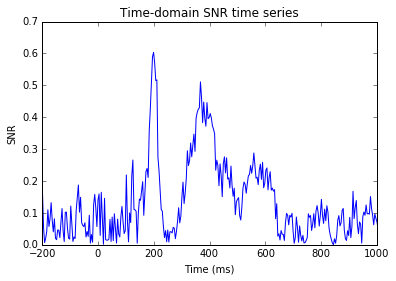

In [40]:
# time-series of SNR
plot(EEGtimes,np.abs(mean(EEGdata[46,:,:],axis=1) / std(EEGdata[46,:,:],axis=1)))
title('Time-domain SNR time series')
setp(gca(),'xlim',[-200, 1000])
_=xlabel('Time (ms)'), ylabel('SNR')

In [41]:
# now compute SNR of peak compared to prestim noise

def dsearchn(X, p):
    disp = X - p
    return np.argmin((disp*disp))


stimeidx = dsearchn(EEGtimes,150)
etimeidx = dsearchn(EEGtimes,400)


# print  'ERP SNR between 150 and 400 ms at FCz: ' + str(max(mean(EEGdata[46,stimeidx:etimeidx,:],axis=1)) / std(mean(EEGdata(46,baselineidx[0]:baselineidx[1],:),axis=1)) )

Figure 18.13

In [42]:
iterations=10;
chan2plot = 'P7' # or FCz
dbcorrect = False

powerByTrialFreq = zeros([len(frequencies),EEGtrials])

start_time = -200 # in ms
end_time   = 1200


chan2use = EEGchanlocslabels == chan2plot

fft_data = fft(reshape(EEGdata[chan2use,:,:],[len(EEGtimes)*EEGtrials] ,'F'),n_conv_pow2);
timeidx = np.array([dsearchn(EEGtimes,tt) for tt in [start_time,end_time]])

In [43]:
for fi in range(len(frequencies)):   
    
    #create wavelet and get its FFT
    wavelet = exp(2*1j*pi*frequencies[fi]*time) * exp(-time**2/(2*(wavelet_cycles /(2*pi*frequencies[fi]))**2))/frequencies[fi]
    fft_wavelet = fft(wavelet,n_conv_pow2)
    
#     % run convolution
    convolution_result = ifft(fft_wavelet*fft_data,n_conv_pow2) * sqrt(wavelet_cycles /(2*pi*frequencies[fi]))
    convolution_result = convolution_result[:n_convolution]
    convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]
    convolution_result = np.abs(reshape(convolution_result,[EEGpnts,EEGtrials],'F'))**2 # reshape and convert to power
    
#     % "gold standard" is average of all trials
    if dbcorrect:
        a = mean(convolution_result,axis=1)
        b = mean(mean(convolution_result[baselineidx[0]:baselineidx[1],:],axis=0),axis=1)
        template = 10*log10(a/b)
        template = template[timeidx[0]:timeidx[1]]
    else:
        template = mean(convolution_result[timeidx[0]:timeidx[1],:],axis=1)
    
#     % normalize template for correlation
    template = (template - mean(template)) / std(template)
    
    for iteri in range(iterations):
        for triali in arange(4,EEGtrials): #% start at 5 trials...
            
            trials2use = random.choice(np.arange(EEGtrials),triali, replace=False)
            
#             % compute power time series from the random selection of trials, and then normalization
            if dbcorrect:
                a = mean(convolution_result[:,trials2use],axis=1)
                b = mean(mean(convolution_result[baselineidx[0]:baselineidx[1],trials2use],axis=0),axis=1)
                tempdat = 10*log10(a/b)
                tempdat = tempdat[timeidx[0]:timeidx[1]]
            else:
                tempdat = mean(convolution_result[timeidx[0]:timeidx[1],trials2use],axis=1)
            
            tempdat = (tempdat - mean(tempdat))/std(tempdat)
#             % compute Pearson correlation. This is a super-fast
#             % implementation of a Pearson correlation via least squares
#             % fit. You'll learn more about this in Chapter 28. 
            powerByTrialFreq[fi,triali] +=  linalg.solve((mat(tempdat)*mat(tempdat).T),(mat(tempdat)*mat(template).T))

powerByTrialFreq /= iterations

/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.


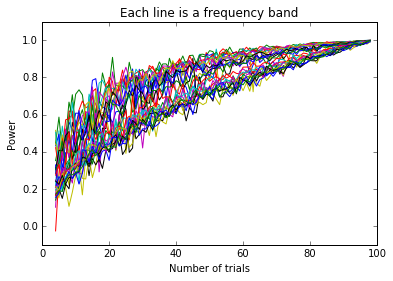

In [44]:
plot(arange(4,EEGtrials),powerByTrialFreq[:,4:].T)
ylim([-.1,1.1])
title('Each line is a frequency band')
_=xlabel('Number of trials'), ylabel('Power')

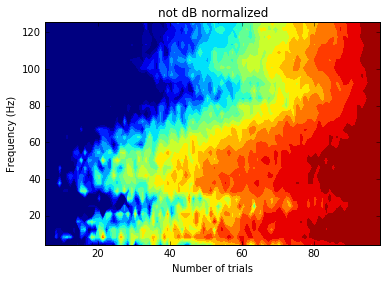

In [45]:
contourf(powerByTrialFreq[:,5:],40,cmap=cm.jet,origin="lower", extent = [5,99,frequencies[0],frequencies[-1]])
clim([.6,1])

xlabel('Number of trials'), ylabel('Frequency (Hz)')
if dbcorrect:
    title('DB normalized')
else: title('not dB normalized')